In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

PATH = r"data/processed/thickener_timeseries_deadband0p27_sp4.parquet"
df = pd.read_parquet(PATH)

print(df.shape)
print(df.columns.tolist())
df.head()

(25920, 43)
['timestamp', 'Qf_pulp_m3h', 'Qf_dilution_m3h', 'Qf_total_m3h', 'Qf_m3h', 'Solids_f_pct', 'Feedwell_Solids_pct', 'FeedDilution_On', 'FeedDilution_factor', 'PSD_fines_idx', 'Clay_pct', 'Clay_idx', 'Floc_gpt', 'FlocActivity_factor', 'FlocEffective_gpt', 'FlocPrepFail_On', 'UF_capacity_factor', 'Qu_base_m3h', 'Qu_sp_delta_m3h', 'Qu_m3h', 'Floc_sp_delta_gpt', 'Solids_u_pct', 'BedLevel_m', 'UF_YieldStress_Pa', 'Bogging_factor', 'RakeTorque_kNm', 'RakeTorque_pct', 'Overflow_Turb_NTU_clean', 'Overflow_Turb_NTU', 'ControlMode', 'OperatorAction', 'RecommendedAction', 'ExpectedTradeoff', 'ActionScore_turb', 'ActionScore_torque', 'WaterRecovery_proxy', 'spec_limit_NTU', 'event_limit_NTU', 'event_now', 'event_type_raw', 'event_type', 'Regime', 'target_event_30m']


,timestamp,Qf_pulp_m3h,Qf_dilution_m3h,Qf_total_m3h,Qf_m3h,Solids_f_pct,Feedwell_Solids_pct,FeedDilution_On,FeedDilution_factor,PSD_fines_idx,...,ActionScore_turb,ActionScore_torque,WaterRecovery_proxy,spec_limit_NTU,event_limit_NTU,event_now,event_type_raw,event_type,Regime,target_event_30m
0,2026-01-01 00:00:00,599.873690,0.0,599.873690,599.873690,30.662771,30.415933,0,1.0,0.137223,...,0.0,0.0,0.230845,200.0,100.0,0,NONE,NONE,NORMAL,0
1,2026-01-01 00:05:00,550.283167,0.0,550.283167,550.283167,31.125261,31.108630,0,1.0,0.127340,...,0.0,0.0,0.338559,200.0,100.0,0,NONE,NONE,NORMAL,0
2,2026-01-01 00:10:00,558.605725,0.0,558.605725,558.605725,29.347387,29.934241,0,1.0,0.123208,...,0.0,0.0,0.264355,200.0,100.0,0,NONE,NONE,NORMAL,0
3,2026-01-01 00:15:00,600.626605,0.0,600.626605,600.626605,32.246723,32.142964,0,1.0,0.119377,...,0.0,0.0,0.393193,200.0,100.0,0,NONE,NONE,NORMAL,0
4,2026-01-01 00:20:00,606.473918,0.0,606.473918,606.473918,32.598267,32.101219,0,1.0,0.113533,...,0.0,0.0,0.342130,200.0,100.0,0,NONE,NONE,NORMAL,0


In [17]:
# Tipos y nulos
na = df.isna().mean().sort_values(ascending=False)
print("Top NA rates:\n", na.head(15))

# Rangos de variables clave
cols = [
    "Overflow_Turb_NTU_clean", "Overflow_Turb_NTU",
    "event_now", "target_event_30m", "event_type",
    "Clay_idx", "PSD_fines_idx", "UF_capacity_factor",
    "Qu_m3h", "BedLevel_m", "UF_YieldStress_Pa",
    "RakeTorque_kNm", "RakeTorque_pct",
    "Floc_gpt", "FlocActivity_factor", "FlocEffective_gpt",
    "FlocPrepFail_On", "ControlMode"
]
print(df[cols].describe(include="all").T)

# Chequeo de timestamp
print(df["timestamp"].min(), df["timestamp"].max())

Top NA rates:
 Qf_m3h                 0.009992
Overflow_Turb_NTU      0.009992
Solids_u_pct           0.009992
Qf_dilution_m3h        0.000000
Qf_total_m3h           0.000000
Solids_f_pct           0.000000
Feedwell_Solids_pct    0.000000
FeedDilution_On        0.000000
FeedDilution_factor    0.000000
Qf_pulp_m3h            0.000000
timestamp              0.000000
Clay_pct               0.000000
PSD_fines_idx          0.000000
FlocActivity_factor    0.000000
Clay_idx               0.000000
dtype: float64
                           count unique   top   freq        mean        std  \
Overflow_Turb_NTU_clean  25920.0    NaN   NaN    NaN   50.720139  45.360457   
Overflow_Turb_NTU        25661.0    NaN   NaN    NaN    49.72191  44.894538   
event_now                25920.0    NaN   NaN    NaN    0.050193   0.218347   
target_event_30m         25920.0    NaN   NaN    NaN    0.050193   0.218347   
event_type                 25920      4  NONE  24619         NaN        NaN   
Clay_idx        

## Distribución de turbidez y prevalencias (objetivo early warning)


#### Histogramas clean vs medida

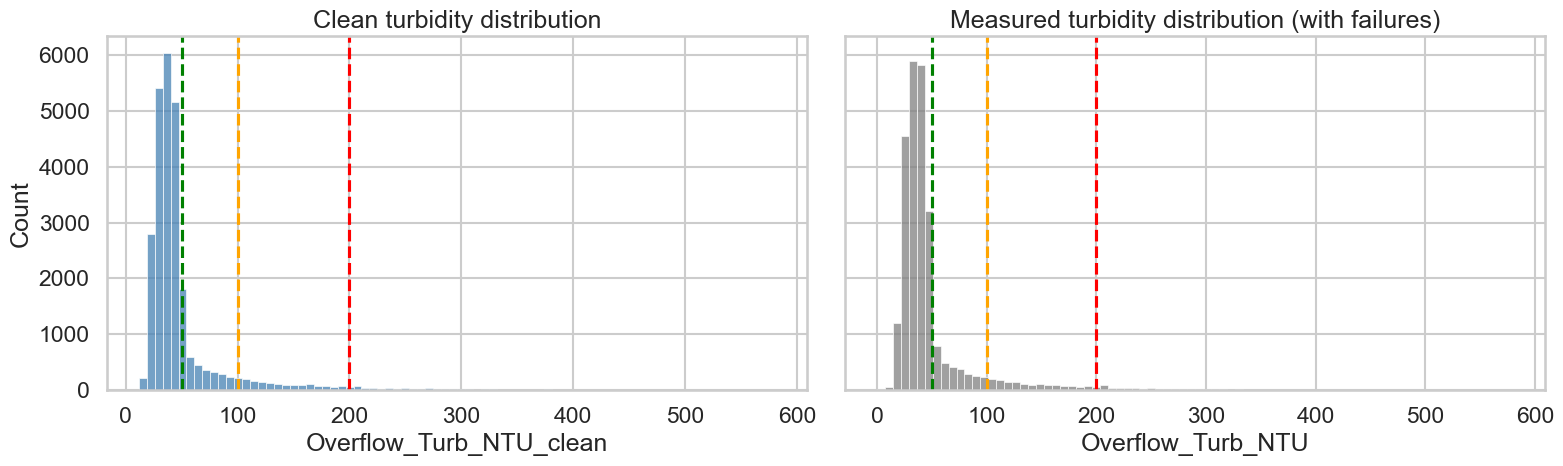

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.histplot(df, x="Overflow_Turb_NTU_clean", bins=80, ax=ax[0], color="steelblue")
ax[0].axvline(50, color="green", ls="--"); ax[0].axvline(100, color="orange", ls="--"); ax[0].axvline(200, color="red", ls="--")
ax[0].set_title("Clean turbidity distribution")

sns.histplot(df, x="Overflow_Turb_NTU", bins=80, ax=ax[1], color="gray")
ax[1].axvline(50, color="green", ls="--"); ax[1].axvline(100, color="orange", ls="--"); ax[1].axvline(200, color="red", ls="--")
ax[1].set_title("Measured turbidity distribution (with failures)")

plt.tight_layout()
plt.show()

#### Prevalencias (event_now y target_event_30m)

In [19]:
rates = {
    "event_now_rate": df["event_now"].mean(),
    "target_event_30m_rate": df["target_event_30m"].mean(),
    "manual_rate": (df["ControlMode"] == "MANUAL").mean(),
    "floc_prep_fail_on_rate": df["FlocPrepFail_On"].mean()
}
rates

{'event_now_rate': np.float64(0.0501929012345679),
 'target_event_30m_rate': np.float64(0.0501929012345679),
 'manual_rate': np.float64(0.2504243827160494),
 'floc_prep_fail_on_rate': np.float64(0.04224537037037037)}

#### Series representativas

Event days: DatetimeIndex(['2026-01-15', '2026-01-16', '2026-01-17', '2026-01-18',
               '2026-01-19', '2026-01-20', '2026-01-21', '2026-01-22',
               '2026-01-23', '2026-01-24'],
              dtype='datetime64[us]', name='timestamp', freq=None)


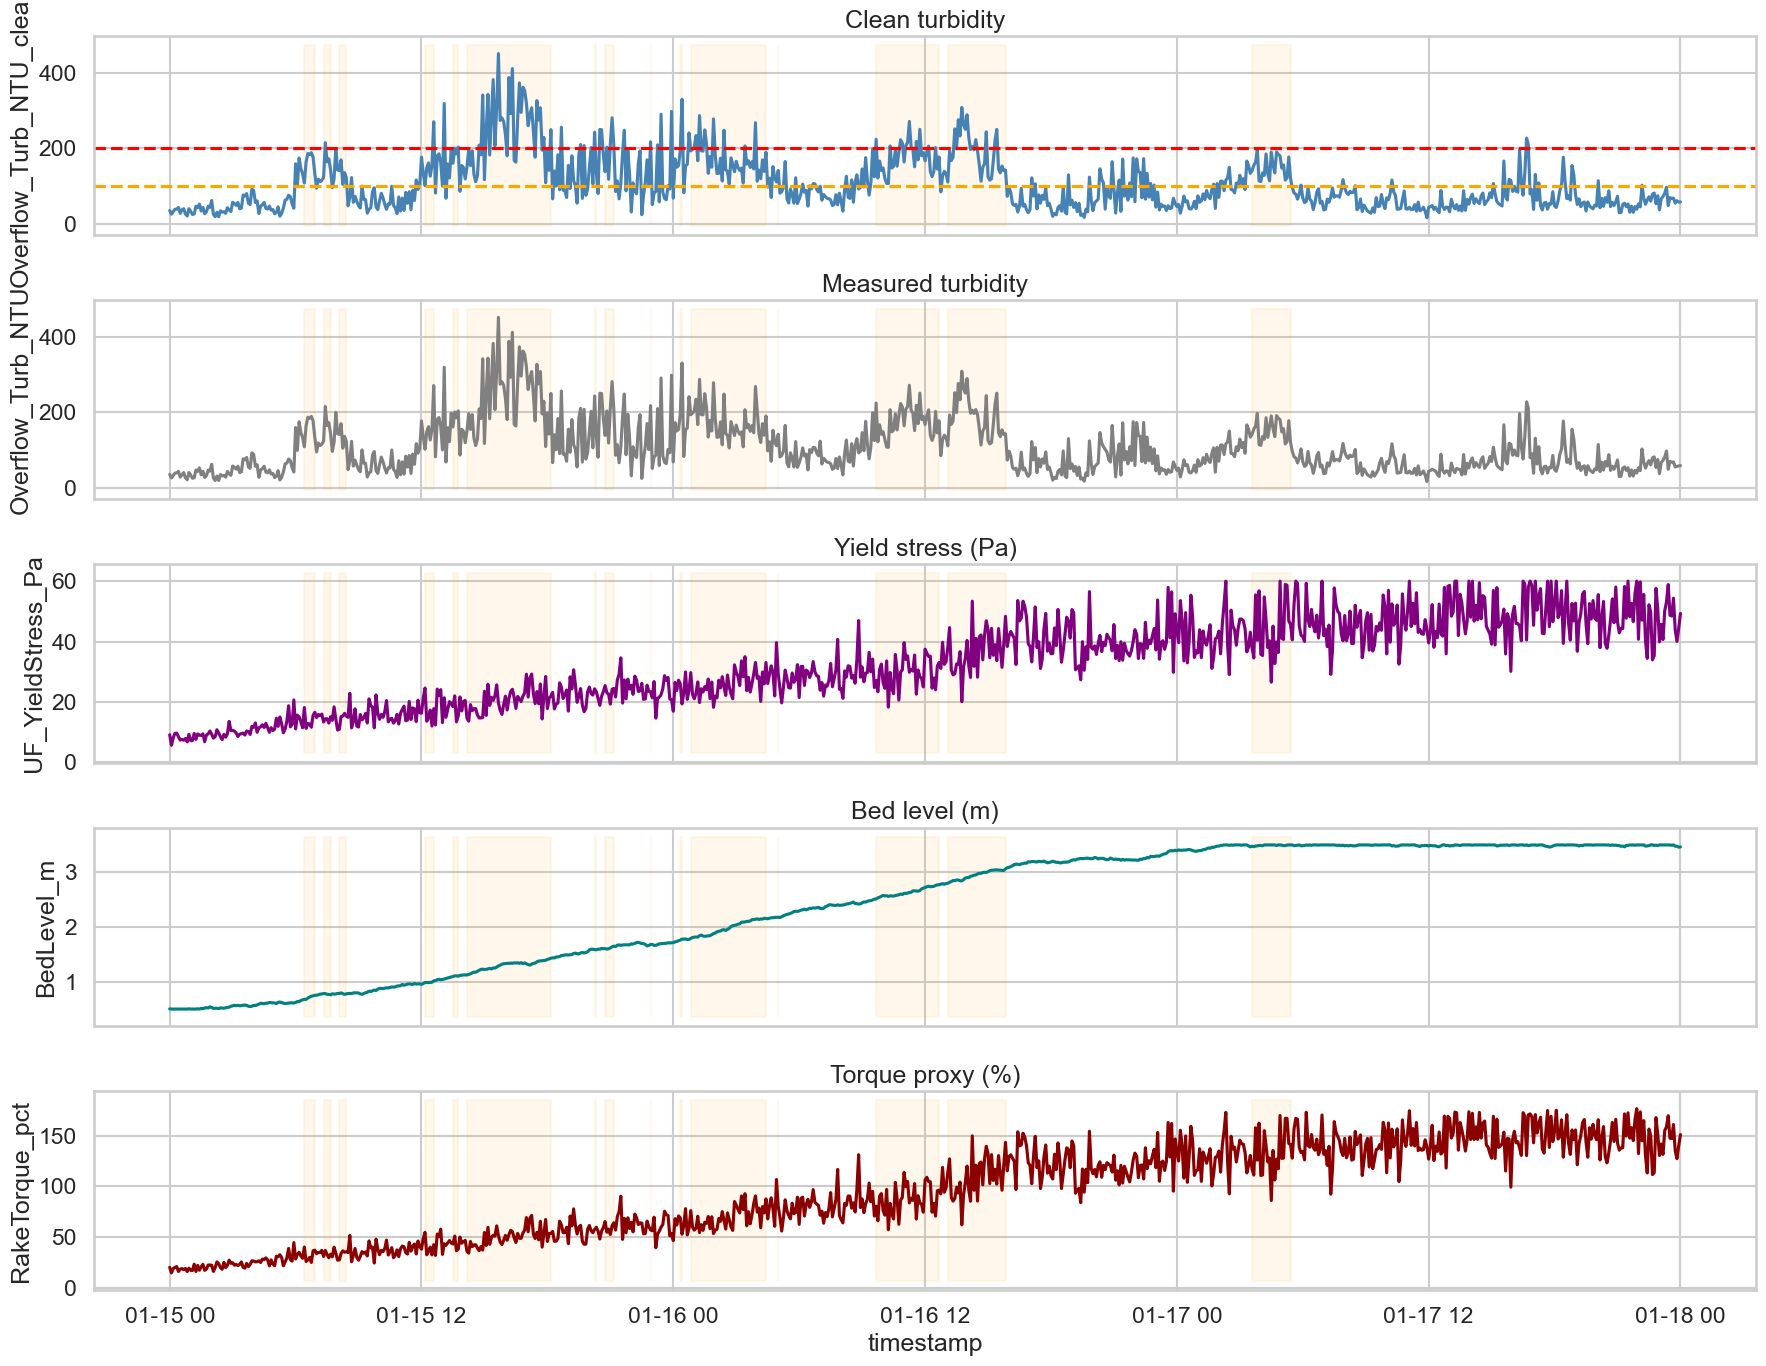

In [31]:
# elige ventana donde haya eventos
df2 = df.set_index("timestamp").sort_index()

# ejemplo: busca un día con eventos
days_with_events = df2.resample("D")["event_now"].max()
event_days = days_with_events[days_with_events > 0].index
print("Event days:", event_days[:10])

start = event_days[0]
end = start + pd.Timedelta(days=3)
w = df2.loc[start:end].copy()

fig, ax = plt.subplots(5, 1, figsize=(18, 14), sharex=True)

sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU_clean", ax=ax[0], color="steelblue")
ax[0].axhline(100, color="orange", ls="--"); ax[0].axhline(200, color="red", ls="--")
ax[0].set_title("Clean turbidity")

sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU", ax=ax[1], color="gray")
ax[1].set_title("Measured turbidity")

sns.lineplot(w, x=w.index, y="UF_YieldStress_Pa", ax=ax[2], color="purple")
ax[2].set_title("Yield stress (Pa)")

sns.lineplot(w, x=w.index, y="BedLevel_m", ax=ax[3], color="teal")
ax[3].set_title("Bed level (m)")

sns.lineplot(w, x=w.index, y="RakeTorque_pct", ax=ax[4], color="darkred")
ax[4].set_title("Torque proxy (%)")

# sombrear eventos
for a in ax:
    ev = w["event_now"].astype(bool).values
    # dibuja fondos semitransparentes en puntos con evento (simple)
    a.fill_between(w.index, a.get_ylim()[0], a.get_ylim()[1], where=ev, color="orange", alpha=0.08, step="pre")

plt.tight_layout()
plt.show()

## Diagnosis: separabilidad de CLAY / UF / FLOC (solo durante evento)

#### Conteo de event_type

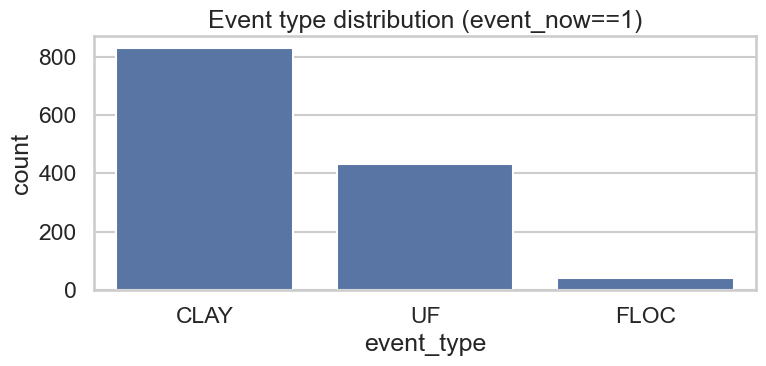

In [32]:
ev = df[df["event_now"] == 1].copy()

plt.figure(figsize=(8,4))
sns.countplot(ev, x="event_type", order=ev["event_type"].value_counts().index)
plt.title("Event type distribution (event_now==1)")
plt.tight_layout()
plt.show()

#### Pairplots/relaciones clave (muestra)

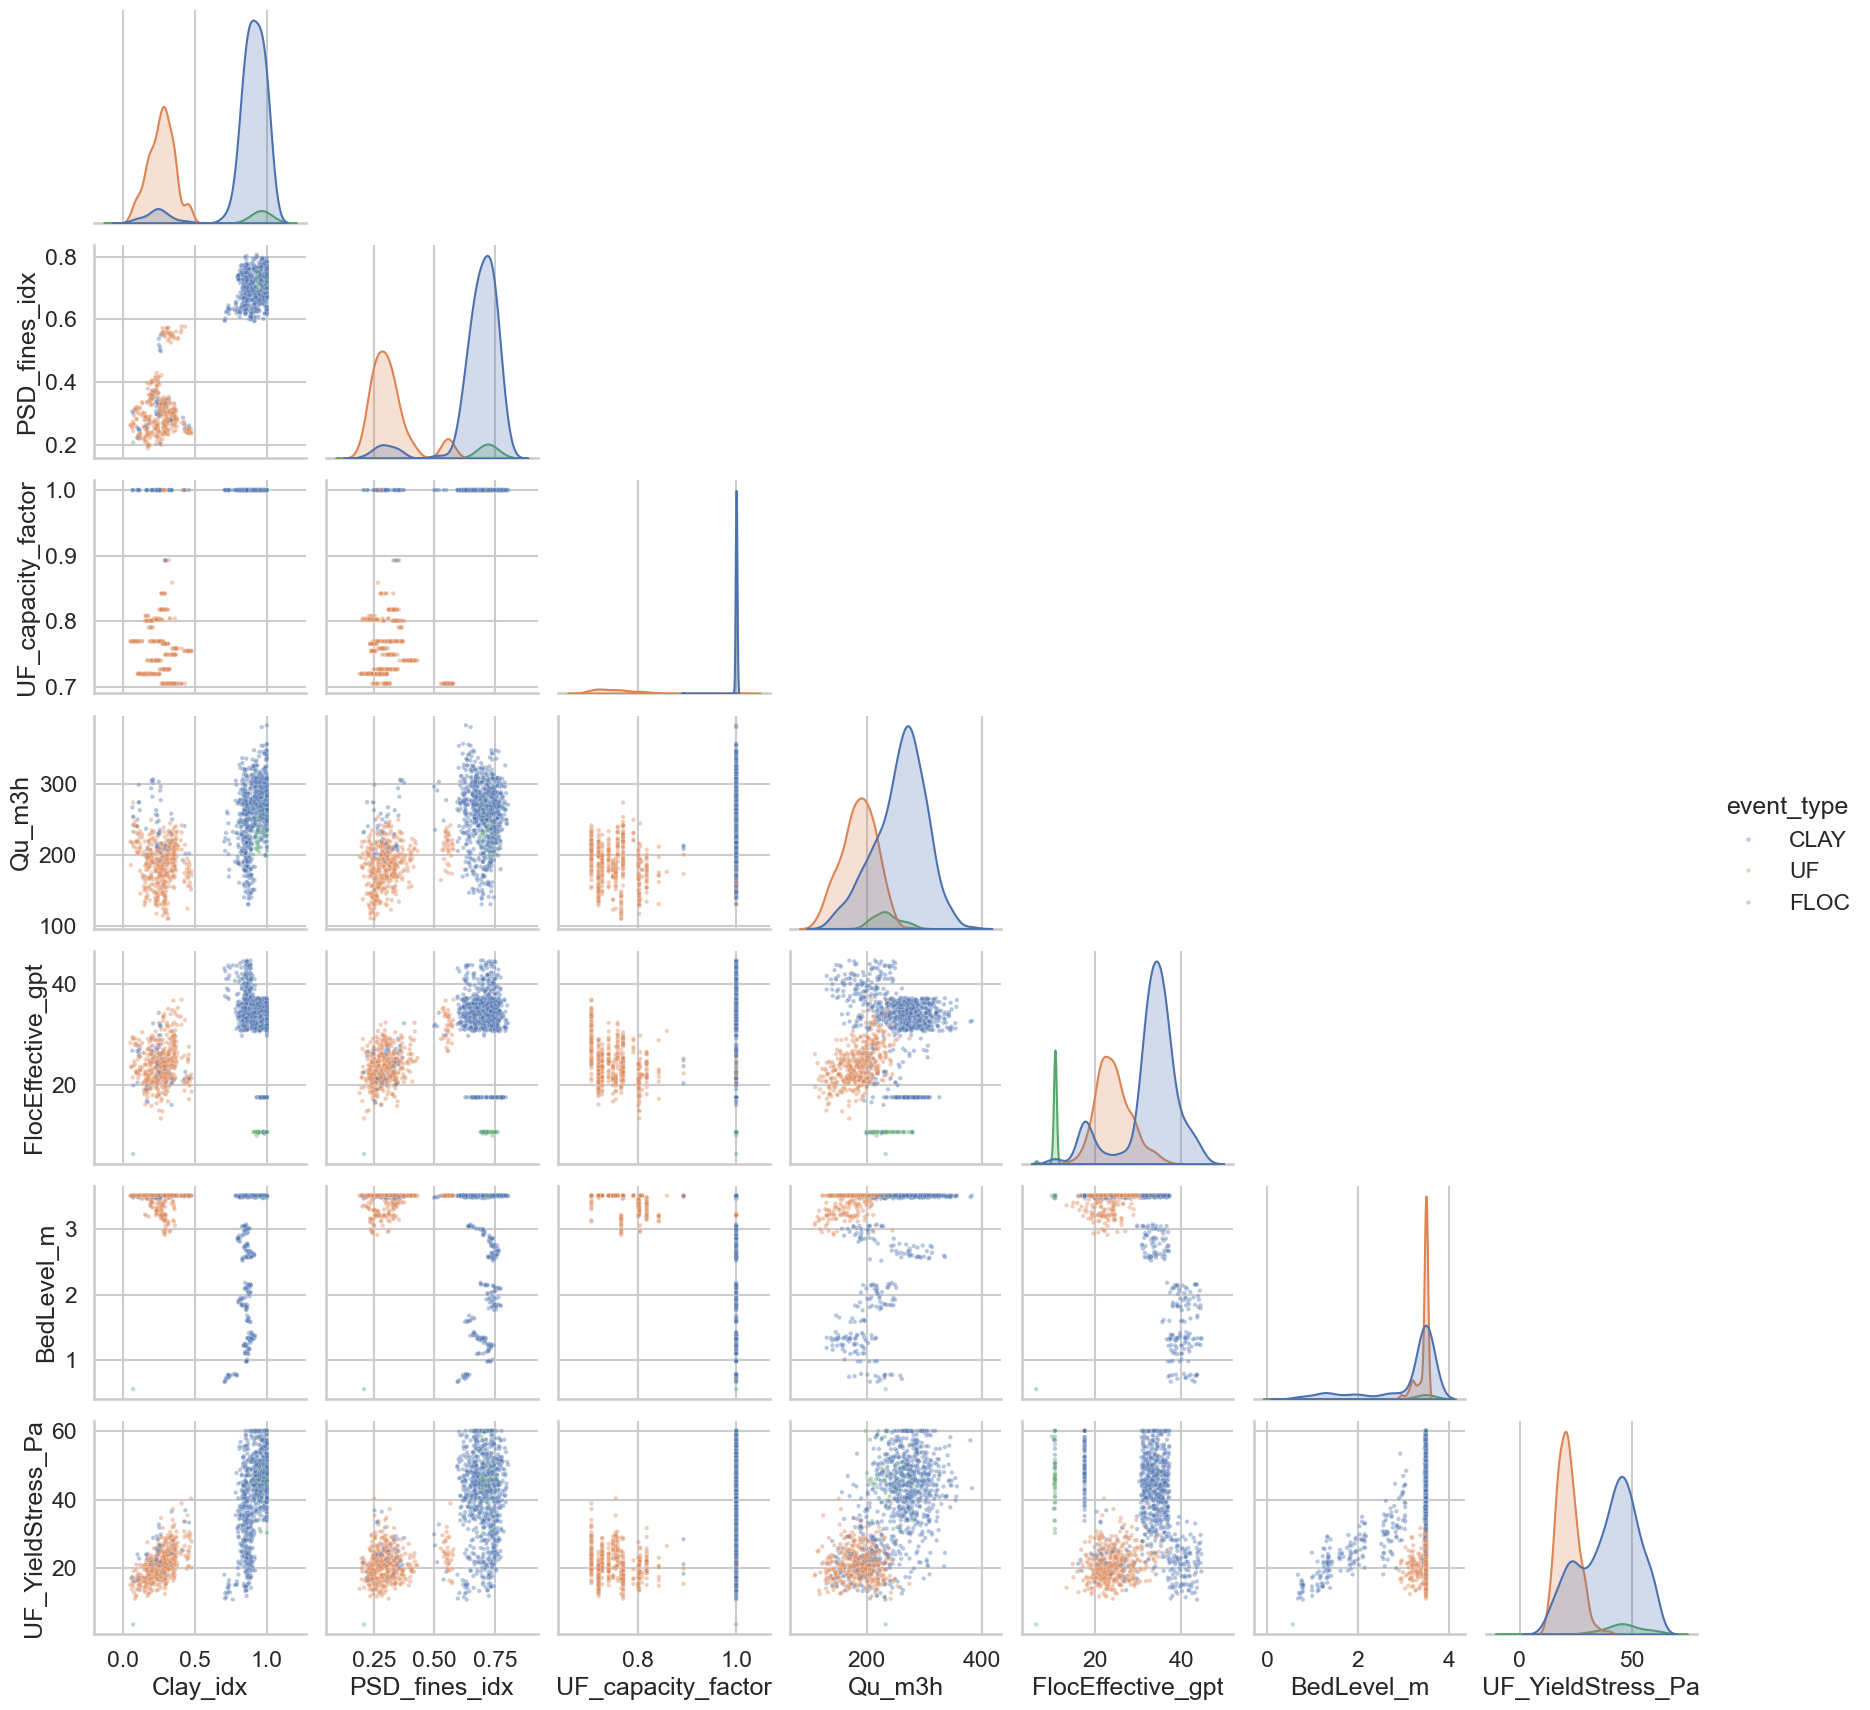

In [33]:
ev = df[df["event_now"] == 1].copy()
evs = ev.sample(min(2500, len(ev)), random_state=42)

vars_ = ["Clay_idx", "PSD_fines_idx", "UF_capacity_factor", "Qu_m3h", "FlocEffective_gpt", "BedLevel_m", "UF_YieldStress_Pa"]
sns.pairplot(evs, vars=vars_, hue="event_type", corner=True, plot_kws=dict(s=10, alpha=0.4))
plt.show()

#### Boxplots por tipo de evento

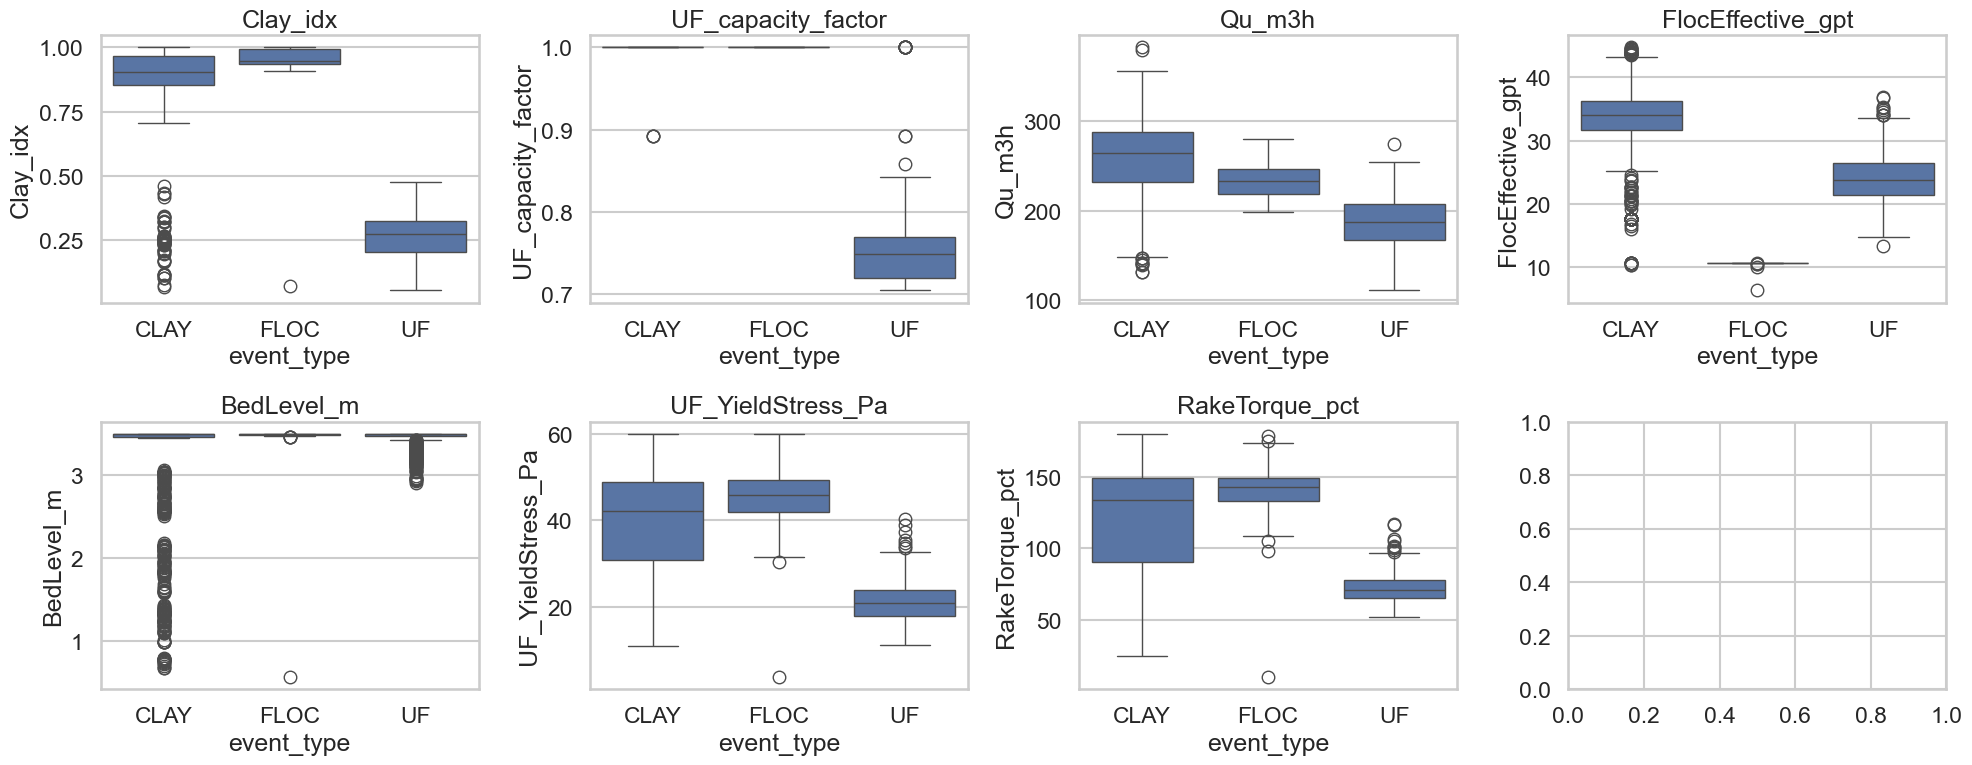

In [34]:
ev = df[df["event_now"] == 1].copy()

features = ["Clay_idx", "UF_capacity_factor", "Qu_m3h", "FlocEffective_gpt", "BedLevel_m", "UF_YieldStress_Pa", "RakeTorque_pct"]
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for ax, f in zip(axes, features):
    sns.boxplot(ev, x="event_type", y=f, ax=ax)
    ax.set_title(f)

plt.tight_layout()
plt.show()

## Early warning: señales 30 minutos antes (comparación target_event_30m)

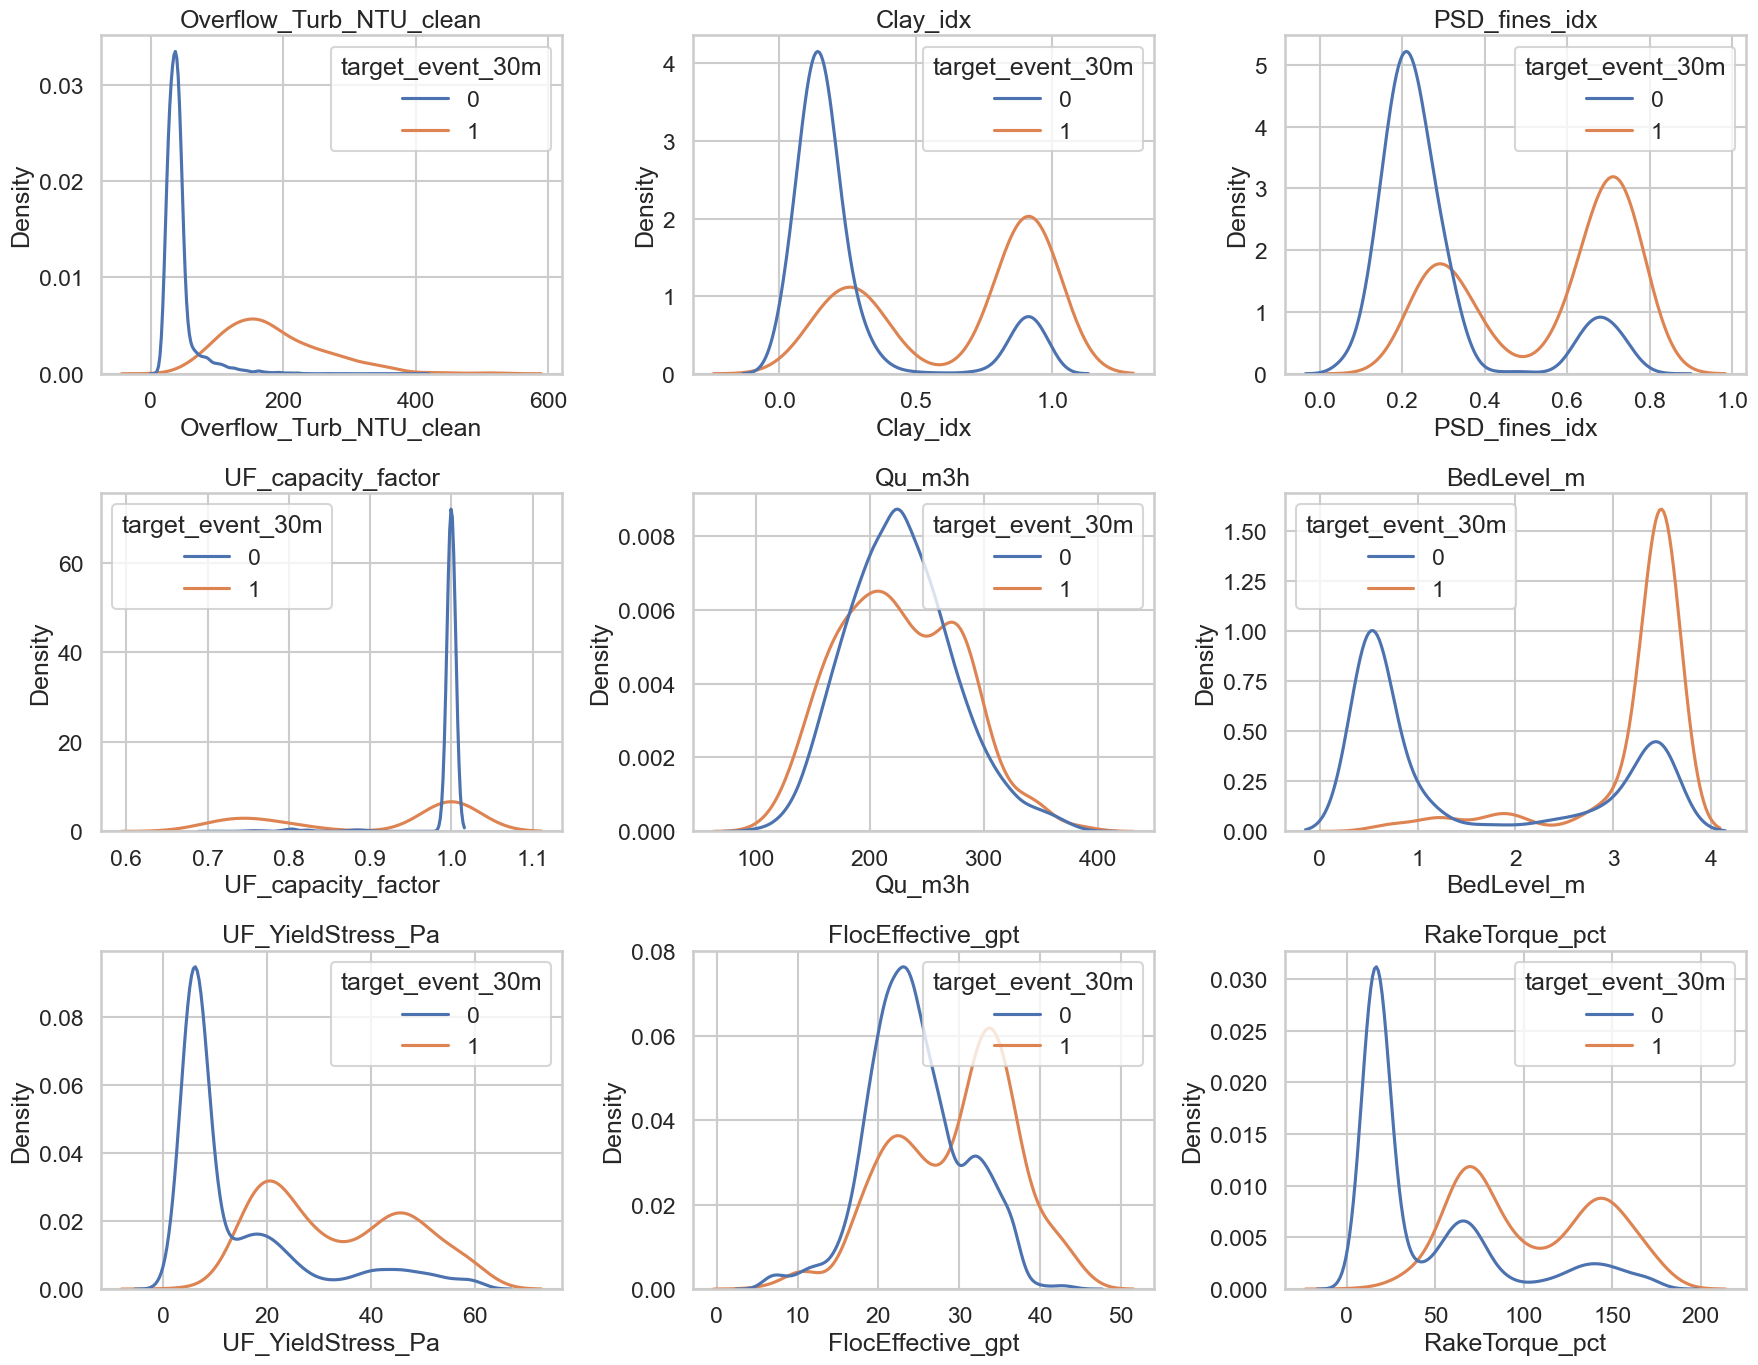

In [35]:
cols = ["Overflow_Turb_NTU_clean", "Clay_idx", "PSD_fines_idx", "UF_capacity_factor", "Qu_m3h", "BedLevel_m",
        "UF_YieldStress_Pa", "FlocEffective_gpt", "RakeTorque_pct"]

sample = df.sample(8000, random_state=1).copy()
sample["target_event_30m"] = sample["target_event_30m"].astype(int)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for ax, c in zip(axes, cols):
    sns.kdeplot(sample, x=c, hue="target_event_30m", common_norm=False, ax=ax)
    ax.set_title(c)

plt.tight_layout()
plt.show()

## Sensor health: diferencias clean vs medida y detección visual de fallas

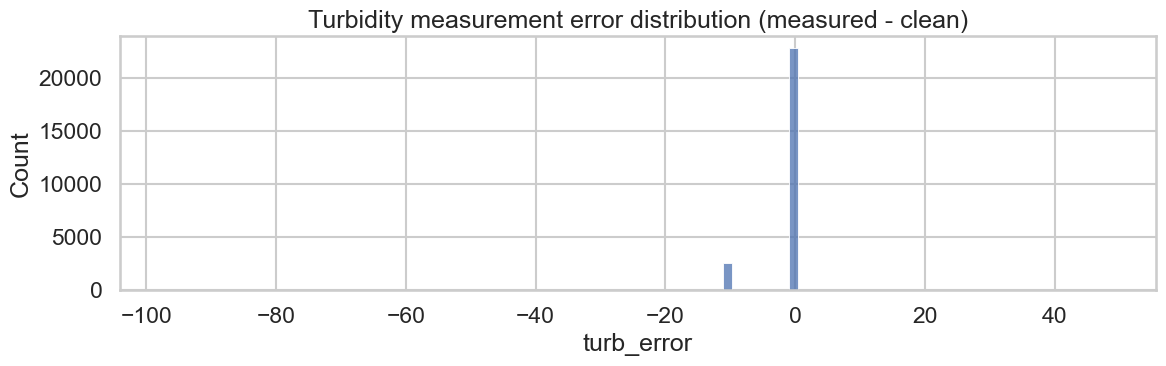

count    25661.000000
mean        -1.004094
std          3.956958
min        -96.816802
1%         -10.000000
5%         -10.000000
95%          0.000000
99%          0.000000
max         48.347776
Name: turb_error, dtype: float64


In [36]:
df_err = df.copy()
df_err["turb_error"] = df_err["Overflow_Turb_NTU"] - df_err["Overflow_Turb_NTU_clean"]

plt.figure(figsize=(12,4))
sns.histplot(df_err, x="turb_error", bins=100)
plt.title("Turbidity measurement error distribution (measured - clean)")
plt.tight_layout()
plt.show()

# puntos extremos
print(df_err["turb_error"].describe(percentiles=[0.01,0.05,0.95,0.99]))

#### Ventana con “stuck” / spikes (busca segmentos con baja variación)

timestamp
2026-01-21 21:05:00    0.0
2026-01-21 21:10:00    0.0
2026-01-21 21:15:00    0.0
2026-01-21 21:20:00    0.0
2026-01-21 21:25:00    0.0
2026-01-21 21:30:00    0.0
2026-01-21 21:35:00    0.0
2026-01-21 21:40:00    0.0
2026-01-21 21:45:00    0.0
2026-01-21 21:50:00    0.0
Name: Overflow_Turb_NTU, dtype: float64


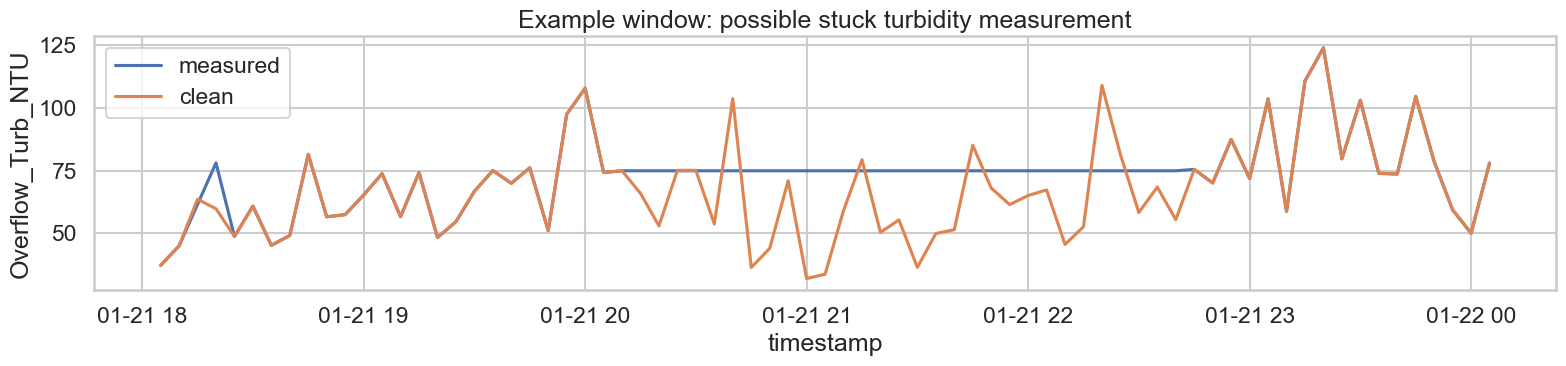

In [37]:
dft = df.set_index("timestamp").sort_index()

# rolling std bajo = potencial "stuck"
roll_std = dft["Overflow_Turb_NTU"].rolling("60min").std()
suspect = roll_std.nsmallest(10)
print(suspect)

# plotea alrededor del peor caso
t0 = suspect.index[0] - pd.Timedelta(hours=3)
t1 = suspect.index[0] + pd.Timedelta(hours=3)
w = dft.loc[t0:t1]

plt.figure(figsize=(16,4))
sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU", label="measured")
sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU_clean", label="clean")
plt.title("Example window: possible stuck turbidity measurement")
plt.tight_layout()
plt.show()

## Playbook: operador vs recomendación, y trade-offs

#### Conteos de acciones

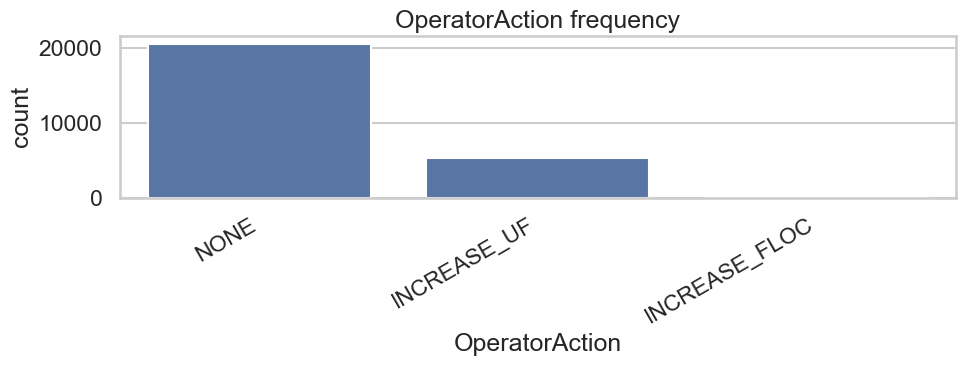

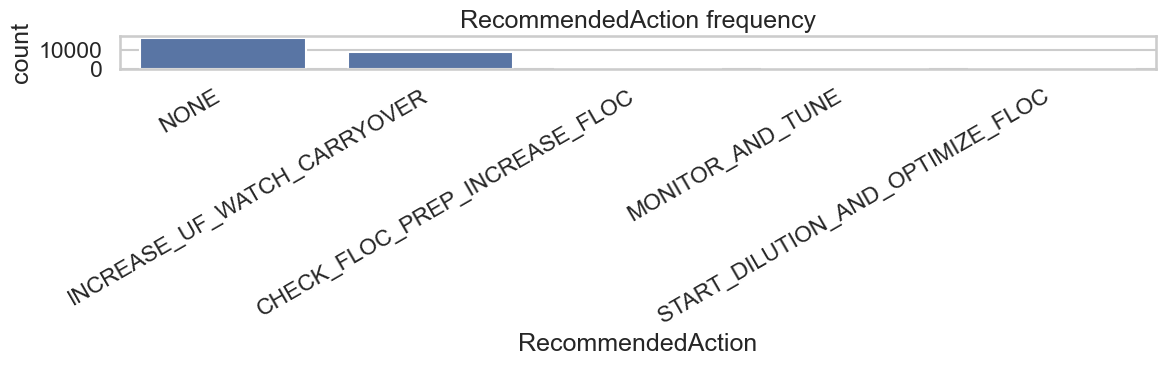

In [38]:
plt.figure(figsize=(10,4))
sns.countplot(df, x="OperatorAction", order=df["OperatorAction"].value_counts().index)
plt.title("OperatorAction frequency")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(df, x="RecommendedAction", order=df["RecommendedAction"].value_counts().index)
plt.title("RecommendedAction frequency")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

#### ¿El operador hace lo recomendado?

Match rate: 0.6091435185185186
Match rate when rec != NONE: 0.0


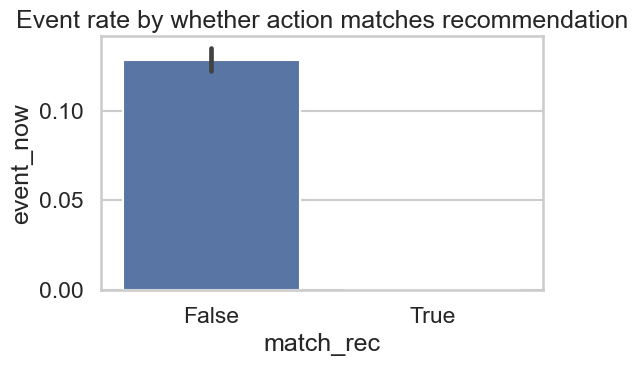

In [39]:
tmp = df.copy()
tmp["match_rec"] = (tmp["OperatorAction"].fillna("NONE") == tmp["RecommendedAction"].fillna("NONE"))

print("Match rate:", tmp["match_rec"].mean())

# Solo cuando hay recomendación (distinto de NONE)
mask = tmp["RecommendedAction"] != "NONE"
print("Match rate when rec != NONE:", tmp.loc[mask, "match_rec"].mean())

plt.figure(figsize=(6,4))
sns.barplot(tmp, x="match_rec", y="event_now", estimator=np.mean)
plt.title("Event rate by whether action matches recommendation")
plt.tight_layout()
plt.show()

#### Trade-off: efecto de subir UF (carryover)

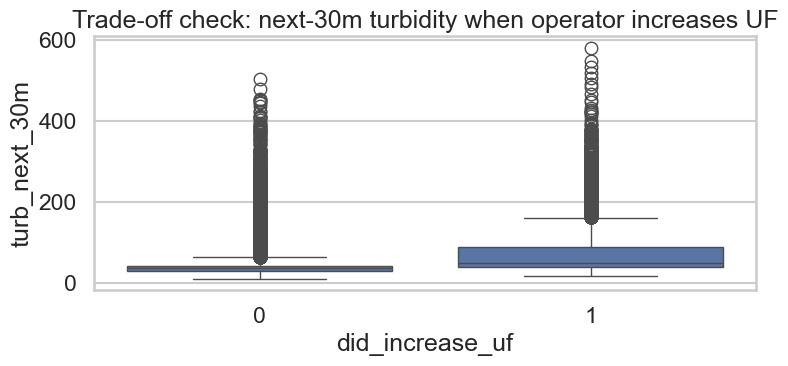

In [40]:
tmp = df.sort_values("timestamp").copy()
tmp["turb_next_30m"] = tmp["Overflow_Turb_NTU_clean"].shift(-6)

mask = tmp["OperatorAction"] == "INCREASE_UF"
sample = tmp[["turb_next_30m", "RakeTorque_pct", "BedLevel_m", "OperatorAction"]].dropna()
sample["did_increase_uf"] = (tmp.loc[sample.index, "OperatorAction"] == "INCREASE_UF").astype(int)

plt.figure(figsize=(8,4))
sns.boxplot(sample, x="did_increase_uf", y="turb_next_30m")
plt.title("Trade-off check: next-30m turbidity when operator increases UF")
plt.tight_layout()
plt.show()